# Exploring Data Cubes with SITELLE

In this notebook, we will explore data cubes from [SITELLE](http://www.cfht.hawaii.edu/Instruments/Sitelle/), an optical imaging spectrometer at the CFHT. We will query and collect data using tools provided by the [Canadian Astronomical Data Centre](http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca ) then make an interactive widget to explore different energy bands in the M33 galaxy.

## Table of Contents
* [1. Introduction](#1.-Introduction)
* [2. Setup](#2.-Setup)
    * [2.1 Using pip](#2.1-Using-pip)
    * [2.2 From source](#2.2-From-source)
* [3. Querying](#3.-Querying)
* [4. Fetching Data](#4.-Fetching-Data)
* [5. Imaging Results](#5.-Imaging-Results)
    * [5.1 Deep frame preview](#5.1-Deep-frame-preview)
    * [5.2 Extract spectrum](#5.2-Extract-spectrum)
    * [5.3 Characteristic lines [OII]3727, [OIII]5007, H$\alpha$](#5.3-Characteristic-lines-[OII]3727,-[OIII]5007,-H$\alpha$)
    * [5.4 Velocity of objects](#5.4-Velocity-of-objects)
* [6. Cube Widget](#6.-Cube-Widget)
    
## 1. Introduction

This tutorial will use packages such as astropy, astroquery, ORCS, matplotlib, and ipywidgets, to make an interactive widget that shows the M33 galaxy in different filters throughout energies centered around different characterisic lines, namely [OII]3727, [OIII]5007, and H$\alpha$.


## 2. Setup
This tutorial will go through some of the basic functionalities of the CADC module of the astroquery package. The CADC module can be installed in two ways:

### 2.1 Using pip
The CADC module is only available with the pre-release of the astroquery module, and can be installed using the command:

```
    pip install --pre --upgrade astroquery
```

### 2.2 From source
Alternatively, you can clone and install from the source:
```
    # If you have a github account:
    git clone git@github.com:astropy/astroquery.git
    # If you do not:
    git clone https://github.com/astropy/astroquery.git
    cd astroquery
    python setup.py install
```
Note that these commands can also be done in a Jupyter notebook by either declaring the code cell a bash cell by pasting `%%bash` at the top of the cell, or preceding each line with a `!`. More information about astroquery can be found at the [astroquery github repository](https://github.com/astropy/astroquery). 


## 3. Querying

The SITELLE data cubes will be in HDF5 file format, which is best suited to store large and complex data. The [ORCS package](https://github.com/thomasorb/orcs) is an analysis engine specifically tailored to handle SITELLE data cubes, so that is what will be used in this tutorial. More information can be found in the [ORCS documentation](https://orcs.readthedocs.io/en/latest/).

In [1]:
import re

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import requests
from astroquery.cadc import Cadc
from ipywidgets import Layout, interact, widgets
from matplotlib.colors import LogNorm, PowerNorm
from orb.core import Lines
from orb.utils.spectrum import compute_radial_velocity
from orcs.core import HDFCube

Let's define what kind of objects we want to retreive from the CADC database. The objects should have the following traits:
- Instrument name is 'SITELLE'
- Collection is 'CFHT'
- Data is of type 'cube'
- Target name contains 'm33_field7'
- [Energy filter](http://www.cfht.hawaii.edu/Instruments/Sitelle/SITELLE_filters.php) is one of 'SN1', 'SN2', or 'SN3'
- Quality is not junk!

Now that we have the list of query parameters, we can build a query in ADQL.

In [2]:
cadc = Cadc()

query = '''SELECT * FROM caom2.Plane AS Plane 
JOIN caom2.Observation AS Observation ON Plane.obsID = Observation.obsID 
WHERE  ( Observation.instrument_name = 'SITELLE' 
AND Observation.collection = 'CFHT' 
AND Plane.dataProductType = 'cube' 
AND LOWER(Observation.target_name) LIKE '%m33_field7%'
AND Plane.energy_bandpassName IN ('SN1', 'SN2', 'SN3') 
AND  ( Plane.quality_flag IS NULL OR Plane.quality_flag != 'junk' ) )'''

job = cadc.run_query(query, 'sync')
results = job.get_results()

cols = [
    'caomPublisherID', 'productID', 'target_name', 'energy_bandpassName',
    'calibrationLevel', 'dataRelease', 'collection', 'proposal_title',
    'instrument_name'
]
results[cols].show_in_notebook()

idx,caomPublisherID,productID,target_name,energy_bandpassName,calibrationLevel,dataRelease,collection,proposal_title,instrument_name
0,ivo://cadc.nrc.ca/CFHT?2326978p/2326978p,2326978p,m33_field7,SN1,2,2018-10-12T00:00:00.000,CFHT,The SIGNALS Project,SITELLE
1,ivo://cadc.nrc.ca/CFHT?2325242p/2325242p,2325242p,m33_field7,SN2,2,2018-10-12T00:00:00.000,CFHT,The SIGNALS Project,SITELLE
2,ivo://cadc.nrc.ca/CFHT?2309128p/2309128p,2309128p,m33_field7,SN3,2,2018-10-12T00:00:00.000,CFHT,The SIGNALS Project,SITELLE


## 4. Fetching Data
Now that we have the table of results, we can use the `get_data_urls` function from the CADC astroquery module to grab all associated URLs, and only select the `.hdf5` access urls. We will also build the filename from the target name, product ID, and energy filter name. 

In [3]:
results_list = []
for idx in range(len(results)):
    # The get_data_urls only accepts a table as input
    urls = cadc.get_data_urls(results[idx:idx + 1], include_auxiliaries=True)

    # Grab the HDF5 access urls only
    hdf5_url = next((url.encode('utf-8') for url in urls if '.hdf5' in url),None)

    if hdf5_url:
        fname = '{}.{}.{}.hdf5'.format(results[idx]['target_name'],
                                       results[idx]['productID'],
                                       results[idx]['energy_bandpassName'])
        results_list.append({'fname': fname, 'url': hdf5_url})

results_list

[{'fname': 'm33_field7.2326978p.SN1.hdf5',
  'url': 'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/CFHT/2326978z.hdf5?RUNID=jatqq9l5mu1ifq9l'},
 {'fname': 'm33_field7.2325242p.SN2.hdf5',
  'url': 'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/CFHT/2325242z.hdf5?RUNID=vqxdczn7k9seamfc'},
 {'fname': 'm33_field7.2309128p.SN3.hdf5',
  'url': 'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/CFHT/2309128z.hdf5?RUNID=dbwvym1m19diwwee'}]

Using the requests package, we will use the access url and write the data under the filename generated in the previous code block. Note that these are large files and this process takes some time.

In [4]:
for product in results_list:
    resp = requests.get(product['url'], stream=True)
    if resp.status_code == 200:
        with open(product['fname'], 'wb') as f:
            for chunk in resp.iter_content(512):
                f.write(chunk)

Now we open the files as HDFCubes and then access and summarize the information in a list of dictionaries. Two points on the cube regions are defined below - one for the HII region and one for the sky region. One corresponds to an area with plenty of action throughout the data cubes, and the other is an area with less activity. The points were chosen by displaying the deep frame preview (demonstrated below) and selecting the two desired points. A quick description of the data list dict entries:
- `cube`: The HDFCube object
- `strong_line`: The name of the most prominent line in the data cube
- `lines`: The names of all the important lines in the data cube
- `band`: The band filter name
- `line_idx`: The index of the point of the maximum HII spectrum
- `sky`: The array of spectrum values through the data cube at circle (xsky, ysky, aperture)
- `spectrum`: The array of spectrum values through the data cube at circle (xrhii, yrhii, aperture) subtracted by the `sky` spectrum
- `axis`: The array of wavenumbers, corresponds to the sky and spectrum arrays
- `wavenumber`: The wavenumber at the maximum HII spectrum point
    

In [5]:
# Load the cubes
cubes = [HDFCube(result['fname']) for result in results_list]
bands = ['SN1', 'SN2', 'SN3']
strong_line_list = ['[OII]3727', '[OIII]5007', 'Halpha']
# Sometimes Hbeta is stronger than [OIII] so use other line list
# strong_line_list = ['[OII]3727', 'Hbeta', 'Halpha']
all_lines_list = [['[OII]3727'], ('[OIII]5007', '[OIII]4959', 'Hbeta'),
                  ('[NII]6548', 'Halpha', '[NII]6583', '[SII]6716',
                   '[SII]6731')]

# The coordinates of the HII region and the sky region
xrhii, yrhii = (690, 270)
xsky, ysky = (1405, 780)
aperture = 3  # Aperture for the spectrum integration (circle)
data_list = []

# Build a list of data dicts to hold info and metadata
for cube, strong_line, all_lines, band in zip(cubes, strong_line_list,
                                              all_lines_list, bands):
    axis, spectrum = cube.extract_spectrum(xrhii, yrhii, aperture, silent=True)
    axis2, sky = cube.extract_spectrum(xsky, ysky, aperture, silent=True)
    spectrum = spectrum - sky
    line_idx = np.where(spectrum == max(spectrum))[0][0]

    data_list.append({
        'cube': cube,
        'strong_line': strong_line,
        'lines': all_lines,
        'band': band,
        'line_idx': line_idx,
        'sky': sky,
        'spectrum': spectrum,
        'axis': axis,
        'wavenumber': axis[line_idx]
    })

INFO| Data shape : (2048, 2064, 171)
INFO| Cube is in WAVENUMBER (cm-1)
INFO| Cube is CALIBRATED in wavenumber
INFO| Data shape : (2048, 2064, 220)
INFO| Cube is in WAVENUMBER (cm-1)
INFO| Cube is CALIBRATED in wavenumber
INFO| Data shape : (2048, 2064, 842)
INFO| Cube is in WAVENUMBER (cm-1)
INFO| Cube is CALIBRATED in wavenumber


## 5. Imaging Results
Now that we have the data downloaded and organized, we can analyze and display it.

### 5.1 Deep frame preview
The [deep frame](http://celeste.phy.ulaval.ca/orcs-doc/examples/deep_wcs.html?highlight=deep%20frame) is the mean of the interferometric images along the scan axis. This will show an overview of each of the data cubes. The HII and sky regions used for the spectrum extraction are also shown (with exagerated radius).

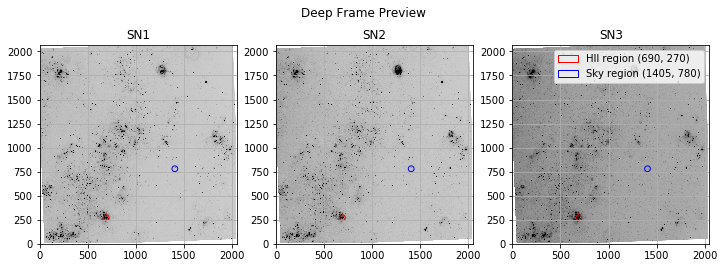

In [6]:
%matplotlib inline
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), frameon=False)

# Define the HII and sky circle artists
def hii_circle(x, y, r):
    return plt.Circle((x, y),
                      r,
                      ec='red',
                      fill=False,
                      label='HII region ({}, {})'.format(x, y))


def sky_circle(x, y, r):
    return plt.Circle((x, y),
                      r,
                      ec='blue',
                      fill=False,
                      label='Sky region ({}, {})'.format(x, y))


for ax, data in zip(axes, data_list):
    deep_frame = data['cube'].get_deep_frame()

    ax.imshow(deep_frame.T,
              origin='bottom-left',
              vmin=np.nanpercentile(deep_frame, 0.05),
              vmax=np.nanpercentile(deep_frame, 99.5),
              cmap='gray_r')

    ax.add_artist(hii_circle(xrhii, yrhii, aperture * 10))
    ax.add_artist(sky_circle(xsky, ysky, aperture * 10))
    ax.set_title(data['band'])
    ax.grid()

plt.legend(handles=[
    hii_circle(xrhii, yrhii, aperture * 10),
    sky_circle(xsky, ysky, aperture * 10)
])
fig.suptitle('Deep Frame Preview');

##### For energy filter is SN1, we want to look at [OII]3727 energy bands. For SN2, we will look at [OIII]5007, and for SN3, we will look at H$\alpha$.

### 5.2 Spectrum

Here we plot the spectrum of the [HII region](https://en.wikipedia.org/wiki/H_II_region) and the sky region.

INFO| Number of integrated pixels: 29


 [==========] [100%] [completed in 0.027 s]                                   
 [==========] [100%] [completed in 0.140 s]                                   


WARNING| /opt/conda/envs/python2/lib/python2.7/site-packages/orcs/core.py:1741: RuntimeWarning: invalid value encountered in sqrt
  noise_counts = np.sqrt(total_counts)

INFO| Number of integrated pixels: 29


 [==========] [100%] [completed in 0.029 s]                                   
 [==========] [100%] [completed in 0.141 s]                                   


INFO| Number of integrated pixels: 29


 [==========] [100%] [completed in 0.029 s]                                   
 [==========] [100%] [completed in 0.124 s]                                   


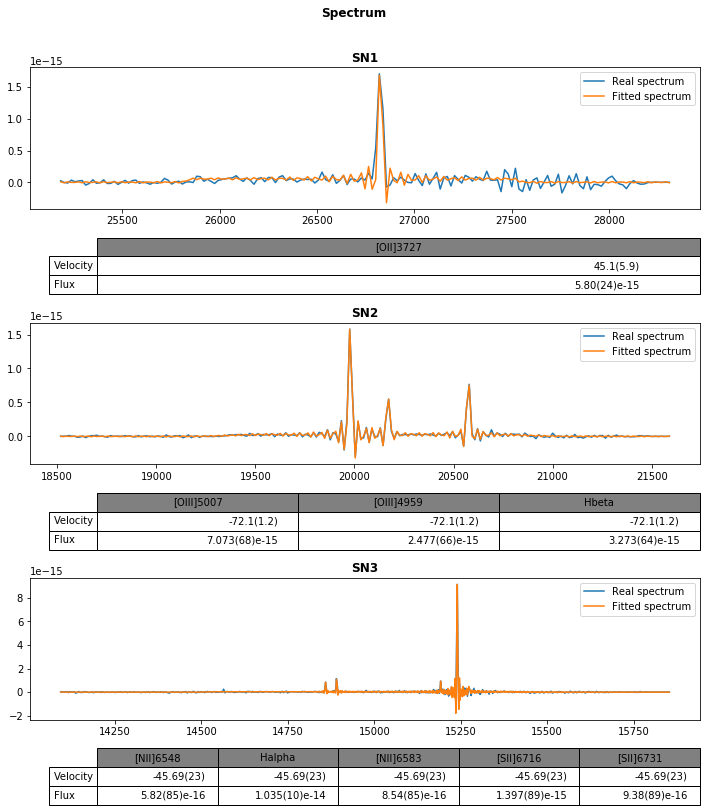

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 12), frameon=False)
fig.subplots_adjust(hspace=0.8)

for ax, data in zip(axes, data_list):
    vel = compute_radial_velocity(data['wavenumber'],
                                  Lines().get_line_cm1(data['strong_line']),
                                  wavenumber=True)

    fit_axis, fit_spectrum, fit_res = data['cube'].fit_lines_in_spectrum(
        xrhii,
        yrhii,
        aperture,
        data['lines'],
        pos_def=['1'],
        pos_cov=vel,
        subtract_spectrum=data['sky'] / (np.pi * aperture**2),
        fmodel='sinc')

    ax.plot(fit_axis, fit_spectrum, label='Real spectrum')
    ax.plot(fit_axis, fit_res['fitted_vector'], label='Fitted spectrum')
    ax.legend(loc=1)
    table = ax.table(cellText=[fit_res['velocity_gvar'], fit_res['flux_gvar']],
                     colLabels=data['lines'],
                     colColours=['grey'] * len(data['lines']),
                     rowLabels=['Velocity', 'Flux'],
                     bbox=[0.1, -0.6, 0.9, 0.4])

    ax.set_title(data['band'], fontweight="bold")

fig.suptitle('Spectrum', y=0.95, fontweight="bold");

### 5.3 Characteristic lines [OII]3727, [OIII]5007, H$\alpha$
These plots show the frames of and around the strongest line for each of the data cubes. 

WARNING| /opt/conda/envs/python2/lib/python2.7/site-packages/matplotlib/colors.py:1257: UserWarning: Power-law scaling on negative values is ill-defined, clamping to 0.
  warnings.warn("Power-law scaling on negative values is "

WARNING| /opt/conda/envs/python2/lib/python2.7/site-packages/matplotlib/colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)



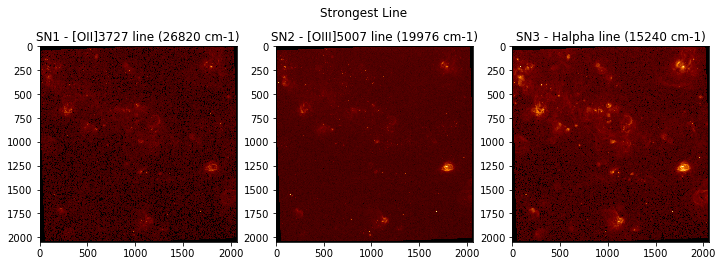

In [8]:
def process_image(img):
    """Returns processed image array"""
    img[np.where(np.isfinite(img) == False)] = 1e-20
    return np.arcsinh(img)


n_frames = 3  # Number of frames around the maximum emission line for the selected region
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), frameon=False)

for ax, data in zip(axes, data_list):
    img_list = [
        data['cube'].get_data_frame(data['line_idx'] + i, silent=True)
        for i in range(-n_frames, n_frames)
    ]
    img = reduce(lambda x, y: x + y, img_list)
    processed_img = process_image(img)

    gamma = 1. / 3.5
    ax.imshow(processed_img, cmap='afmhot', norm=PowerNorm(gamma=gamma))
    ax.set_title('{} - {} line ({:0.0f} cm-1)'.format(data['band'],
                                                      data['strong_line'],
                                                      data['wavenumber']))

fig.suptitle('Strongest Line');

### 5.4 Velocity of objects
Using the ORB function, we compute the radial velocities of the objects at the strongest lines.

In [9]:
for data in data_list:
    vel = compute_radial_velocity(data['wavenumber'],
                                  Lines().get_line_cm1(data['strong_line']),
                                  wavenumber=True)
    print('{} - {} velocity: {:0.2f} km/s'.format(data['band'],
                                                  data['strong_line'], vel))

SN1 - [OII]3727 velocity: 95.12 km/s
SN2 - [OIII]5007 velocity: -47.87 km/s
SN3 - Halpha velocity: -48.54 km/s


## 6. Cube Widget
Now we will make an interactive widget that will use a slider to scroll through the frames around all the lines for each of the data cubes. First we will iterate through the cube - from a bit before the first line to a bit after the last line - putting each image into a list. This will speed up the interactivness of the widget later on. We will also use a step of size `step` for the `x` and `y` dimensions of the image for increased widget speed.


In [10]:
def find_nearest(array, value):
    """Function that finds the nearest value in an array. 
    Useful to find the position of the lines in the axis 
    for i_min and i_max"""
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]


def get_i_min_max(axis, lines, n_ext):
    """Gets the min and max index of the axis array that covers
    all the lines with n_ext indices on either side"""
    lines_cm1 = Lines().get_line_cm1(lines)

    return ((np.where(axis == find_nearest(axis, np.min(lines_cm1)))[0][0] - n_ext),
            (np.where(axis == find_nearest(axis, np.max(lines_cm1)))[0][0] + n_ext))


step = 4
n_frames = 5
for data in data_list:
    cube = data['cube']

    lines_wavenumber = Lines().get_line_cm1(data['lines'])
    i_min, i_max = get_i_min_max(data['axis'], data['lines'], n_frames)

    data['img_list_idx'] = (i_min, i_max)
    data['img_list'] = [
        process_image(cube.get_data_frame(i, silent=True).T[::step, ::step])
        for i in range(i_min, i_max)
    ]

<IPython.core.display.Javascript object>


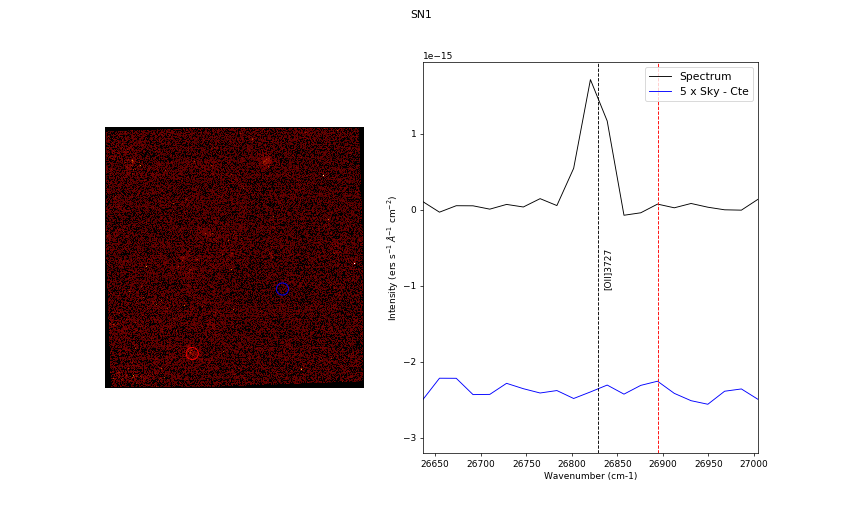

aW50ZXJhY3RpdmUoY2hpbGRyZW49KFNlbGVjdGlvblNsaWRlcihkZXNjcmlwdGlvbj11J1dhdmVudW1iZXI6JywgbGF5b3V0PUxheW91dCh3aWR0aD11JzcwMHB4JyksIG9wdGlvbnM9KCgnMjbigKY=


In [24]:
# Call notebook magic twice to avoid bug
%matplotlib notebook

%matplotlib notebook


def plot_widget(data, n_frames=5):
    """Plots the data list dict object as an interactive plot.
    The i_min and i_max paramters are the index of the data frame to
    be used"""
    img_list, axis, lines = data['img_list'], data['axis'], data['lines']

    fig, (ax0, ax1) = plt.subplots(nrows=1,
                                   ncols=2,
                                   figsize=(13, 8),
                                   gridspec_kw={'width_ratios': [1, 1.3]},
                                   frameon=False)
    ax1.plot(axis, data['spectrum'], c='k', linewidth=1, label='Spectrum')
    ax1.plot(axis,
             5 * data['sky'] - 2.5e-15,
             c='blue',
             linewidth=1,
             label='5 x Sky - Cte')

    i_min, i_max = data['img_list_idx']
    xlim = (axis[i_min - 5], axis[i_max + 5])
    ax1.set_xlim(xlim)

    ax1.set_xlabel('Wavenumber (cm-1)')
    ax1.set_ylabel('Intensity (ers s$^{-1}$ $\AA$$^{-1}$ cm$^{-2}$)')

    for line in lines:
        x_line = Lines().get_line_cm1(line)
        ax1.axvline(x=x_line, c='black', linestyle='--', linewidth=1)
        ax1.annotate(line, (x_line + (xlim[1] - xlim[0]) * 0.015, -6e-16),
                     rotation=90,
                     annotation_clip=False)

    ax1.legend(fontsize=12, loc=1)
    ax0.axis('off')
    im_plot = ax0.imshow(img_list[0],
                         origin='bottom-left',
                         interpolation='nearest',
                         cmap='afmhot',
                         norm=PowerNorm(gamma=gamma),
                         clim=[-1e-19, 8e-16])

    ax1.axvline(x=axis[0], color='r', linestyle='--', linewidth=1)
    fig.suptitle(data['band'])
    ax0.add_artist(hii_circle(xrhii / step, yrhii / step, aperture * 4))
    ax0.add_artist(sky_circle(xsky / step, ysky / step, aperture * 4))

    def plot_image(wavenumber):
        """Function to update the image and wavenumber line on interaction with the slider"""
        idx = np.where(axis == wavenumber)[0][0]
        img = img_list[idx - i_min]
        im_plot.set_data(img)
        ax1.lines.remove(ax1.lines[-1])
        ax1.axvline(x=axis[idx], color='r', linestyle='--', linewidth=1)

    interact(plot_image,
             wavenumber=widgets.SelectionSlider(
                 options=[('{:0.0f} (cm-1)'.format(wavenumber), wavenumber)
                          for wavenumber in axis[i_min:i_max]],
                 description='Wavenumber:',
                 layout={'width': '700px'},
                 style={'description_width': 'initial'}))


plot_widget(data_list[0])

<IPython.core.display.Javascript object>


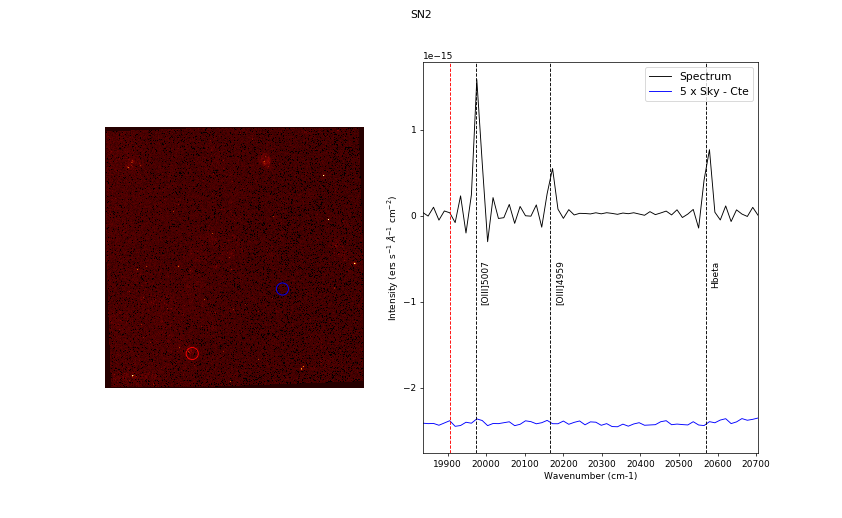

aW50ZXJhY3RpdmUoY2hpbGRyZW49KFNlbGVjdGlvblNsaWRlcihkZXNjcmlwdGlvbj11J1dhdmVudW1iZXI6JywgbGF5b3V0PUxheW91dCh3aWR0aD11JzcwMHB4JyksIG9wdGlvbnM9KCgnMTnigKY=


In [25]:
plot_widget(data_list[1])

In [ ]:
plot_widget(data_list[2])